<a href="https://colab.research.google.com/github/maytlim/doh_data/blob/main/labresults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
show_past_days = 5

In [2]:
import requests
import re
import pandas as pd
import datetime
import gdown
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
try:
  import pdfx
except ModuleNotFoundError:
  !pip -q install pdfx
  import pdfx

     |████████████████████████████████| 5.6 MB 7.8 MB/s 
     |████████████████████████████████| 178 kB 73.3 MB/s 
     |████████████████████████████████| 3.6 MB 56.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires chardet<4,>=3.0.2, but you have chardet 4.0.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
 #Code from https://gist.github.com/korakot/51a917e1f53891d53be223439b0f75c1
from google.colab import auth
auth.authenticate_user()  # must authenticate

'''list all ids of files directly under folder folder_id'''
def folder_list(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3', cache_discovery=False).files()
  #gdrive = build('drive', 'v3').files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  return [f['id'] for f in res['files']]

'''download all files from a gdrive folder to current directory'''
def folder_download(folder_id):
  for fid in folder_list(folder_id):
    !gdown -q --id $fid

'''list all ids and filenames of files directly under folder folder_id'''
def folder_list_named(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3', cache_discovery=False).files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  return [[f['id'], f['name']] for f in res['files']]

'''download specific file from a gdrive folder to current directory'''
def folder_download_specific(folder_id, search_term):
  for fid, fname in folder_list_named(folder_id):
    found = re.search(search_term, fname)
    if found:
      !gdown -q --id $fid

In [5]:
def folder_list_test(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3', cache_discovery=False).files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  for f in res['files']:
    print(f)
  return [f['id'] for f in res['files']]

In [6]:
ddrop_readme = requests.get('http://bit.ly/DataDropPH').url
ddrop_readme = ddrop_readme.split('/')[-1].split('?')[0]
#print(ddrop_readme)
!rm *.pdf #remove existing pdf file before downloading 
folder_download(ddrop_readme)

rm: cannot remove '*.pdf': No such file or directory


In [7]:
readme_pdf = !ls *.pdf
readme_pdf = readme_pdf[0][1:-1]
readme_pdf
pdfx_tmp = pdfx.PDFx(readme_pdf)
ddlinks = pdfx_tmp.get_references_as_dict()

In [8]:
month_day = readme_pdf.split('_')
month = int(month_day[0][-2:])
day = int(month_day[1][:2])
month, day
year = 2022
print('DOH DataDrop Release:', year, month, day)

DOH DataDrop Release: 2022 1 9


In [9]:
search_term = 'Testing Aggregates'
downloaded = False
for ddlink in ddlinks['url']:
  if downloaded == False:
    if ddlink[:15] == 'https://bit.ly/' and ddlink[-3:] != 'ive':
      datadrop = requests.get(ddlink).url
      datadrop = datadrop.split('/')[-1].split('?')[0]
      #folder_download(datadrop)
      folder_download_specific(datadrop, search_term)
      print(search_term, '... downloaded')
      downloaded = True
  else:
    continue

Testing Aggregates ... downloaded


In [10]:
data_date = datetime.datetime(year, month, day)
#data_dir ='DOH COVID Data Drop_'  + data_date.strftime('%Y%m%d') + '/'

In [11]:
# testing aggregates - reporting labs
labs_filename = 'DOH COVID Data Drop_ ' + data_date.strftime('%Y%m%d') + ' - 07 Testing Aggregates.csv'
print('testing labs report:', labs_filename)

testing labs report: DOH COVID Data Drop_ 20220109 - 07 Testing Aggregates.csv


In [12]:
df_labs = pd.read_csv(labs_filename)
df_labs.keys()
date_labels = ['report_date']
for label in date_labels:
  df_labs[label] = pd.to_datetime(df_labs[label])

In [13]:
df_labs['daily_positivity'] = df_labs['daily_output_positive_individuals']/df_labs['daily_output_unique_individuals']

In [14]:
#df_labs.keys()

In [15]:
def show_hospital_details(df, hosp_name, by='daily_output_positive_individuals', min_threshold=15, show_num=5):
  filter = (df[by] > min_threshold) & (df_labs['facility_name'] == hosp_name)
  show_columns = ['report_date','daily_output_unique_individuals',
                  'daily_output_positive_individuals', 'daily_positivity','facility_name']
  return df[filter][show_columns].tail(show_num) 

In [16]:
def show_labs_list(df, by='daily_positivity', report_date='2021-12-27', cutoff_positivity=0.08, cutoff_count=100):
  filter = (df[by] > cutoff_positivity) & \
    (df['report_date'] == report_date) & \
    (df['daily_output_unique_individuals'] > cutoff_count)
  show_columns = ['report_date', 'daily_output_unique_individuals', 
                  'daily_output_positive_individuals', 'daily_positivity', 'facility_name']
  return df[filter][show_columns]

In [17]:
for t in range(1, show_past_days):
  show_date = data_date - datetime.timedelta(days=t)
  rpt_date = show_date.strftime('%Y-%m-%d')
  df = show_labs_list(df_labs, by='daily_positivity', report_date=rpt_date, 
               cutoff_positivity=0.30, cutoff_count=100)
  df.sort_values(by='daily_output_positive_individuals', inplace=True, ascending=False)
  with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 2,
                       'display.max_colwidth', -1,
                       ):
    display(df)
  df_all = df_labs[df_labs['report_date']==rpt_date]
  stats = df_all.sum()
  print(rpt_date, stats['daily_output_positive_individuals'], stats['daily_output_unique_individuals'])

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
33338,2022-01-08,5299.0,2667.0,0.50,Detoxicare Molecular Diagnostics Laboratory
84192,2022-01-08,3165.0,1462.0,0.46,Philippine Red Cross - Port Area
110008,2022-01-08,1674.0,977.0,0.58,The Lord's Grace Medical and Industrial Clinic
61141,2022-01-08,1945.0,819.0,0.42,"Marilao Medical and Diagnosc Clinic, Inc. - Pasay City"
48534,2022-01-08,1349.0,734.0,0.54,JT Cenica Medical Health System
95383,2022-01-08,1528.0,688.0,0.45,"Safeguard DNA Diagnostics, Inc"
61650,2022-01-08,1618.0,682.0,0.42,"Marilao Medical and Diagnostic Clinc, Inc."
893,2022-01-08,1170.0,670.0,0.57,AL Molecular Diagnostic Laboratory
85217,2022-01-08,1525.0,657.0,0.43,Philippine Red Cross Clark Molecular Laboratory
67792,2022-01-08,1105.0,612.0,0.55,New World Diagnostic Premium Medical Branch


2022-01-08 31391.0 69755.0


,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
33337,2022-01-07,5146.0,2207.0,0.43,Detoxicare Molecular Diagnostics Laboratory
86241,2022-01-07,2189.0,1299.0,0.59,Philippine Red Cross Logistics & Multipurpose Center
110007,2022-01-07,1907.0,1211.0,0.64,The Lord's Grace Medical and Industrial Clinic
84191,2022-01-07,2453.0,1193.0,0.49,Philippine Red Cross - Port Area
45613,2022-01-07,1446.0,1043.0,0.72,Hi-Precision Diagnostics (QC)
67791,2022-01-07,1974.0,996.0,0.50,New World Diagnostic Premium Medical Branch
61649,2022-01-07,1667.0,885.0,0.53,"Marilao Medical and Diagnostic Clinc, Inc."
79067,2022-01-07,2632.0,809.0,0.31,Philippine Airport Diagnostic Laboratory
70514,2022-01-07,1538.0,787.0,0.51,"Olayn Medical Laboratory, Inc."
48533,2022-01-07,1439.0,659.0,0.46,JT Cenica Medical Health System


2022-01-07 35093.0 79853.0


,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
33336,2022-01-06,5367.0,2259.0,0.42,Detoxicare Molecular Diagnostics Laboratory
84190,2022-01-06,2345.0,1334.0,0.57,Philippine Red Cross - Port Area
110006,2022-01-06,2816.0,1096.0,0.39,The Lord's Grace Medical and Industrial Clinic
67790,2022-01-06,1914.0,1080.0,0.56,New World Diagnostic Premium Medical Branch
86240,2022-01-06,2061.0,1060.0,0.51,Philippine Red Cross Logistics & Multipurpose Center
81523,2022-01-06,2018.0,1012.0,0.50,Philippine Red Cross (PRC)
79066,2022-01-06,3020.0,1004.0,0.33,Philippine Airport Diagnostic Laboratory
48532,2022-01-06,1439.0,821.0,0.57,JT Cenica Medical Health System
24087,2022-01-06,1211.0,768.0,0.63,Chinese General Hospital
45612,2022-01-06,1221.0,693.0,0.57,Hi-Precision Diagnostics (QC)


2022-01-06 33975.0 77655.0


,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
67789,2022-01-05,2391.0,1276.0,0.53,New World Diagnostic Premium Medical Branch
33335,2022-01-05,3414.0,1208.0,0.35,Detoxicare Molecular Diagnostics Laboratory
79065,2022-01-05,3195.0,1191.0,0.37,Philippine Airport Diagnostic Laboratory
84189,2022-01-05,2208.0,1178.0,0.53,Philippine Red Cross - Port Area
86239,2022-01-05,2125.0,1105.0,0.52,Philippine Red Cross Logistics & Multipurpose Center
110005,2022-01-05,2663.0,924.0,0.35,The Lord's Grace Medical and Industrial Clinic
61138,2022-01-05,1572.0,832.0,0.53,"Marilao Medical and Diagnosc Clinic, Inc. - Pasay City"
24086,2022-01-05,1191.0,637.0,0.53,Chinese General Hospital
48531,2022-01-05,1175.0,613.0,0.52,JT Cenica Medical Health System
70512,2022-01-05,990.0,586.0,0.59,"Olayn Medical Laboratory, Inc."


2022-01-05 28979.0 72160.0


In [18]:
show_hospital_details(df_labs, "Ospital ng Imus", 
                      by='daily_positivity', min_threshold=0.08, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
72060,2021-10-02,270.0,32.0,0.118519,Ospital ng Imus
72061,2021-10-03,211.0,24.0,0.113744,Ospital ng Imus
72116,2021-11-27,30.0,3.0,0.100000,Ospital ng Imus
72146,2021-12-27,1431.0,153.0,0.106918,Ospital ng Imus
72147,2021-12-28,1106.0,107.0,0.096745,Ospital ng Imus
72154,2022-01-04,1285.0,368.0,0.286381,Ospital ng Imus
72155,2022-01-05,1309.0,126.0,0.096257,Ospital ng Imus
72156,2022-01-06,463.0,239.0,0.516199,Ospital ng Imus
72157,2022-01-07,1666.0,261.0,0.156663,Ospital ng Imus
72158,2022-01-08,799.0,425.0,0.531915,Ospital ng Imus


In [19]:
show_hospital_details(df_labs, "Manila Doctors Hospital", 
                      by='daily_output_positive_individuals', min_threshold=50, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
57444,2021-09-25,447.0,61.0,0.136465,Manila Doctors Hospital
57540,2021-12-30,199.0,61.0,0.306533,Manila Doctors Hospital
57541,2021-12-31,214.0,62.0,0.289720,Manila Doctors Hospital
57543,2022-01-02,487.0,156.0,0.320329,Manila Doctors Hospital
57544,2022-01-03,495.0,163.0,0.329293,Manila Doctors Hospital
57545,2022-01-04,640.0,273.0,0.426563,Manila Doctors Hospital
57546,2022-01-05,639.0,270.0,0.422535,Manila Doctors Hospital
57547,2022-01-06,784.0,366.0,0.466837,Manila Doctors Hospital
57548,2022-01-07,803.0,321.0,0.399751,Manila Doctors Hospital
57549,2022-01-08,953.0,418.0,0.438615,Manila Doctors Hospital


In [20]:
show_hospital_details(df_labs, "Chinese General Hospital", 
                      by='daily_output_positive_individuals', min_threshold=100, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
23989,2021-09-30,828.0,128.0,0.154589,Chinese General Hospital
23991,2021-10-02,818.0,147.0,0.179707,Chinese General Hospital
23994,2021-10-05,697.0,106.0,0.152080,Chinese General Hospital
24080,2021-12-30,525.0,200.0,0.380952,Chinese General Hospital
24081,2021-12-31,423.0,200.0,0.472813,Chinese General Hospital
24082,2022-01-01,653.0,227.0,0.347626,Chinese General Hospital
24083,2022-01-02,567.0,234.0,0.412698,Chinese General Hospital
24084,2022-01-03,667.0,341.0,0.511244,Chinese General Hospital
24086,2022-01-05,1191.0,637.0,0.534845,Chinese General Hospital
24087,2022-01-06,1211.0,768.0,0.634187,Chinese General Hospital


In [21]:
show_hospital_details(df_labs, "UP-PGH Molecular Laboratory", 
                      by='daily_output_positive_individuals', min_threshold=50, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
115187,2021-12-30,385.0,59.0,0.153247,UP-PGH Molecular Laboratory
115188,2021-12-31,495.0,90.0,0.181818,UP-PGH Molecular Laboratory
115189,2022-01-01,285.0,79.0,0.277193,UP-PGH Molecular Laboratory
115190,2022-01-02,136.0,53.0,0.389706,UP-PGH Molecular Laboratory
115191,2022-01-03,277.0,116.0,0.418773,UP-PGH Molecular Laboratory
115192,2022-01-04,589.0,317.0,0.538200,UP-PGH Molecular Laboratory
115193,2022-01-05,454.0,276.0,0.607930,UP-PGH Molecular Laboratory
115194,2022-01-06,678.0,358.0,0.528024,UP-PGH Molecular Laboratory
115195,2022-01-07,981.0,466.0,0.475025,UP-PGH Molecular Laboratory
115196,2022-01-08,859.0,413.0,0.480792,UP-PGH Molecular Laboratory


In [22]:
show_hospital_details(df_labs, "Philippine Children's Medical Center", 
                      by='daily_output_positive_individuals', min_threshold=50, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
79674,2021-12-29,1061.0,65.0,0.061263,Philippine Children's Medical Center
79676,2021-12-31,850.0,91.0,0.107059,Philippine Children's Medical Center
79677,2022-01-01,882.0,94.0,0.106576,Philippine Children's Medical Center
79678,2022-01-02,942.0,93.0,0.098726,Philippine Children's Medical Center
79679,2022-01-03,532.0,209.0,0.392857,Philippine Children's Medical Center
79680,2022-01-04,443.0,209.0,0.471783,Philippine Children's Medical Center
79681,2022-01-05,370.0,191.0,0.516216,Philippine Children's Medical Center
79682,2022-01-06,926.0,559.0,0.603672,Philippine Children's Medical Center
79683,2022-01-07,671.0,391.0,0.582712,Philippine Children's Medical Center
79684,2022-01-08,630.0,341.0,0.541270,Philippine Children's Medical Center


In [23]:
show_hospital_details(df_labs, "The Lord's Grace Medical and Industrial Clinic", 
                      by='daily_output_positive_individuals', min_threshold=300, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
109900,2021-09-22,1515.0,329.0,0.217162,The Lord's Grace Medical and Industrial Clinic
110000,2021-12-31,961.0,304.0,0.316337,The Lord's Grace Medical and Industrial Clinic
110001,2022-01-01,950.0,320.0,0.336842,The Lord's Grace Medical and Industrial Clinic
110002,2022-01-02,1689.0,610.0,0.361160,The Lord's Grace Medical and Industrial Clinic
110003,2022-01-03,2118.0,855.0,0.403683,The Lord's Grace Medical and Industrial Clinic
110004,2022-01-04,2836.0,940.0,0.331453,The Lord's Grace Medical and Industrial Clinic
110005,2022-01-05,2663.0,924.0,0.346977,The Lord's Grace Medical and Industrial Clinic
110006,2022-01-06,2816.0,1096.0,0.389205,The Lord's Grace Medical and Industrial Clinic
110007,2022-01-07,1907.0,1211.0,0.635029,The Lord's Grace Medical and Industrial Clinic
110008,2022-01-08,1674.0,977.0,0.583632,The Lord's Grace Medical and Industrial Clinic


In [24]:
show_hospital_details(df_labs, "Best Diagnostic Corporation", 
                      by='daily_output_positive_individuals', min_threshold=30, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
10246,2021-10-11,73.0,33.0,0.452055,Best Diagnostic Corporation
10247,2021-10-12,126.0,31.0,0.246032,Best Diagnostic Corporation
10254,2021-10-19,171.0,35.0,0.204678,Best Diagnostic Corporation
10324,2021-12-28,180.0,38.0,0.211111,Best Diagnostic Corporation
10325,2021-12-29,212.0,93.0,0.438679,Best Diagnostic Corporation
10326,2021-12-30,309.0,121.0,0.391586,Best Diagnostic Corporation
10328,2022-01-01,241.0,99.0,0.410788,Best Diagnostic Corporation
10329,2022-01-02,558.0,206.0,0.369176,Best Diagnostic Corporation
10330,2022-01-03,377.0,169.0,0.448276,Best Diagnostic Corporation
10332,2022-01-05,427.0,280.0,0.655738,Best Diagnostic Corporation


In [25]:
show_hospital_details(df_labs, "Detoxicare Molecular Diagnostics Laboratory", 
                      by='daily_output_positive_individuals', min_threshold=300, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
33244,2021-10-06,3077.0,336.0,0.109197,Detoxicare Molecular Diagnostics Laboratory
33330,2021-12-31,2400.0,458.0,0.190833,Detoxicare Molecular Diagnostics Laboratory
33331,2022-01-01,1973.0,366.0,0.185504,Detoxicare Molecular Diagnostics Laboratory
33332,2022-01-02,1901.0,467.0,0.245660,Detoxicare Molecular Diagnostics Laboratory
33333,2022-01-03,3024.0,872.0,0.288360,Detoxicare Molecular Diagnostics Laboratory
33334,2022-01-04,3381.0,1077.0,0.318545,Detoxicare Molecular Diagnostics Laboratory
33335,2022-01-05,3414.0,1208.0,0.353837,Detoxicare Molecular Diagnostics Laboratory
33336,2022-01-06,5367.0,2259.0,0.420906,Detoxicare Molecular Diagnostics Laboratory
33337,2022-01-07,5146.0,2207.0,0.428877,Detoxicare Molecular Diagnostics Laboratory
33338,2022-01-08,5299.0,2667.0,0.503303,Detoxicare Molecular Diagnostics Laboratory


In [26]:
show_hospital_details(df_labs, "Detoxicare Molecular Diagnostics Laboratory", 
                      by='daily_positivity', min_threshold=0.15, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
33238,2021-09-30,3032.0,519.0,0.171174,Detoxicare Molecular Diagnostics Laboratory
33330,2021-12-31,2400.0,458.0,0.190833,Detoxicare Molecular Diagnostics Laboratory
33331,2022-01-01,1973.0,366.0,0.185504,Detoxicare Molecular Diagnostics Laboratory
33332,2022-01-02,1901.0,467.0,0.245660,Detoxicare Molecular Diagnostics Laboratory
33333,2022-01-03,3024.0,872.0,0.288360,Detoxicare Molecular Diagnostics Laboratory
33334,2022-01-04,3381.0,1077.0,0.318545,Detoxicare Molecular Diagnostics Laboratory
33335,2022-01-05,3414.0,1208.0,0.353837,Detoxicare Molecular Diagnostics Laboratory
33336,2022-01-06,5367.0,2259.0,0.420906,Detoxicare Molecular Diagnostics Laboratory
33337,2022-01-07,5146.0,2207.0,0.428877,Detoxicare Molecular Diagnostics Laboratory
33338,2022-01-08,5299.0,2667.0,0.503303,Detoxicare Molecular Diagnostics Laboratory


In [27]:
show_hospital_details(df_labs, "San Lazaro Hospital (SLH)", by='daily_output_positive_individuals', min_threshold=50, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
96736,2021-09-16,217.0,67.0,0.308756,San Lazaro Hospital (SLH)
96737,2021-09-17,166.0,65.0,0.391566,San Lazaro Hospital (SLH)
96739,2021-09-19,175.0,55.0,0.314286,San Lazaro Hospital (SLH)
96751,2021-10-01,177.0,53.0,0.299435,San Lazaro Hospital (SLH)
96842,2021-12-31,120.0,73.0,0.608333,San Lazaro Hospital (SLH)
96845,2022-01-03,215.0,116.0,0.539535,San Lazaro Hospital (SLH)
96846,2022-01-04,276.0,260.0,0.942029,San Lazaro Hospital (SLH)
96847,2022-01-05,376.0,206.0,0.547872,San Lazaro Hospital (SLH)
96848,2022-01-06,480.0,350.0,0.729167,San Lazaro Hospital (SLH)
96850,2022-01-08,674.0,299.0,0.443620,San Lazaro Hospital (SLH)


In [28]:
show_hospital_details(df_labs, "Sta. Ana Hospital - Closed System Molecular Laboratory (RT PCR)", 
                      by='daily_output_positive_individuals', min_threshold=100, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
105572,2021-09-24,549.0,107.0,0.194900,Sta. Ana Hospital - Closed System Molecular La...
105573,2021-09-25,544.0,109.0,0.200368,Sta. Ana Hospital - Closed System Molecular La...
105669,2021-12-30,349.0,187.0,0.535817,Sta. Ana Hospital - Closed System Molecular La...
105670,2021-12-31,234.0,105.0,0.448718,Sta. Ana Hospital - Closed System Molecular La...
105673,2022-01-03,218.0,148.0,0.678899,Sta. Ana Hospital - Closed System Molecular La...
105674,2022-01-04,486.0,298.0,0.613169,Sta. Ana Hospital - Closed System Molecular La...
105675,2022-01-05,454.0,251.0,0.552863,Sta. Ana Hospital - Closed System Molecular La...
105676,2022-01-06,391.0,238.0,0.608696,Sta. Ana Hospital - Closed System Molecular La...
105677,2022-01-07,540.0,340.0,0.629630,Sta. Ana Hospital - Closed System Molecular La...
105678,2022-01-08,463.0,283.0,0.611231,Sta. Ana Hospital - Closed System Molecular La...


In [29]:
show_hospital_details(df_labs, "Philippine Red Cross (PRC)", 
                      by='daily_output_positive_individuals', min_threshold=100, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
81462,2021-11-06,1845.0,125.0,0.067751,Philippine Red Cross (PRC)
81515,2021-12-29,789.0,106.0,0.134347,Philippine Red Cross (PRC)
81516,2021-12-30,966.0,143.0,0.148033,Philippine Red Cross (PRC)
81517,2021-12-31,384.0,117.0,0.304688,Philippine Red Cross (PRC)
81520,2022-01-03,500.0,267.0,0.534000,Philippine Red Cross (PRC)
81521,2022-01-04,580.0,302.0,0.520690,Philippine Red Cross (PRC)
81522,2022-01-05,858.0,375.0,0.437063,Philippine Red Cross (PRC)
81523,2022-01-06,2018.0,1012.0,0.501487,Philippine Red Cross (PRC)
81524,2022-01-07,651.0,408.0,0.626728,Philippine Red Cross (PRC)
81525,2022-01-08,683.0,368.0,0.538799,Philippine Red Cross (PRC)


In [30]:
show_hospital_details(df_labs, "Philippine Red Cross - Port Area", 
                      by='daily_output_positive_individuals', min_threshold=200, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
84182,2021-12-29,1052.0,207.0,0.196768,Philippine Red Cross - Port Area
84183,2021-12-30,1307.0,409.0,0.312930,Philippine Red Cross - Port Area
84184,2021-12-31,747.0,204.0,0.273092,Philippine Red Cross - Port Area
84185,2022-01-01,423.0,241.0,0.569740,Philippine Red Cross - Port Area
84187,2022-01-03,1056.0,262.0,0.248106,Philippine Red Cross - Port Area
84188,2022-01-04,2991.0,1854.0,0.619860,Philippine Red Cross - Port Area
84189,2022-01-05,2208.0,1178.0,0.533514,Philippine Red Cross - Port Area
84190,2022-01-06,2345.0,1334.0,0.568870,Philippine Red Cross - Port Area
84191,2022-01-07,2453.0,1193.0,0.486343,Philippine Red Cross - Port Area
84192,2022-01-08,3165.0,1462.0,0.461927,Philippine Red Cross - Port Area


In [31]:
def juxtapose_spreads(df, show_dates):
  n_dates = len(show_dates)
  filter = []
  xhigh = 0
  for i, show_date in enumerate(show_dates):
    filter.append(df['report_date'] == show_date)
    xhigh = max(df[filter[i]]['daily_output_positive_individuals'].max(), xhigh)

  #fig, axes = plt.subplots(ncols=n_dates, figsize=(n_dates*5 + 2, 5))
  fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

  for i in range(n_dates):
    j = i//2
    k = i%2
    pts = axes[j][k].plot(df[filter[i]]['daily_positivity']*100, 
         df[filter[i]]['daily_output_positive_individuals'],
         'ro', alpha=0.33)
    axes[j][k].set_xlabel('positivity rate (%)')
    axes[j][k].set_ylabel('positive individuals')
    axes[j][k].set_ylim(bottom=0, top=xhigh+5)
    axes[j][k].set_xlim(right=100) 
    axes[j][k].set_title(show_dates[i] + ' : ' + str(int(df[filter[i]]['daily_output_positive_individuals'].sum())) + ' positive individuals')
    show_date = data_date - datetime.timedelta(days=1)
    latest_date = show_date.strftime('%Y-%m-%d')
    if show_dates[i] == latest_date:
      axes[j][k].set_title(show_dates[i] + ' : ' + str(int(df[filter[i]]['daily_output_positive_individuals'].sum())) + ' positive individuals (prelim)')

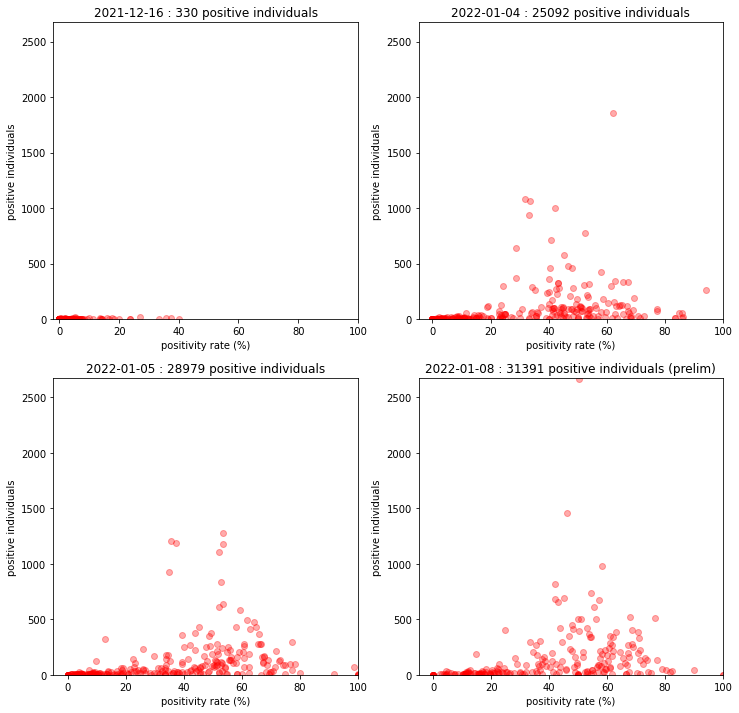

In [32]:
show_date = data_date - datetime.timedelta(days=1)
latest_date = show_date.strftime('%Y-%m-%d')
juxtapose_spreads(df_labs, ['2021-12-16', '2022-01-04', '2022-01-05', latest_date])

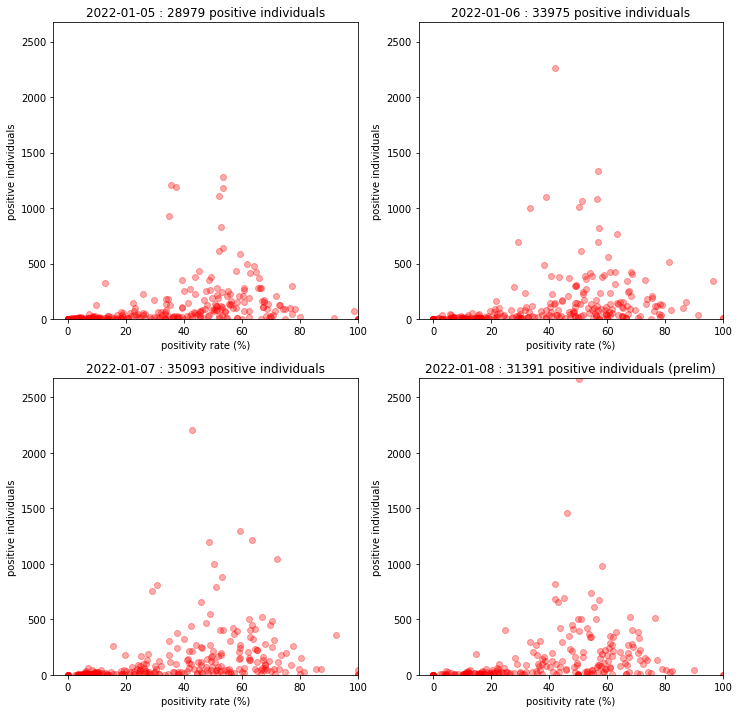

In [33]:
days_back = [4, 3, 2, 1]
show_dates = []
show_dates_string = []
for i in days_back:
  show_dates.append(data_date - datetime.timedelta(days=i))
  show_dates_string.append(show_dates[-1].strftime('%Y-%m-%d'))
juxtapose_spreads(df_labs, show_dates_string)

In [36]:
df_labs[(df_labs['report_date']==latest_date) & 
        (df_labs['daily_output_positive_individuals'] > 400)][['facility_name', 'report_date', 
                                                              'daily_output_unique_individuals', 
                                                              'daily_output_positive_individuals',
                                                              'daily_positivity']].sort_values(by='daily_positivity', ascending=False)

,facility_name,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity
77973,Pasig City Molecular Laboratory,2022-01-08,665.0,509.0,0.765414
66349,National Kidney and Transplant Institute,2022-01-08,584.0,401.0,0.686644
55282,Lung Center of the Philippines (LCP),2022-01-08,762.0,518.0,0.679790
110008,The Lord's Grace Medical and Industrial Clinic,2022-01-08,1674.0,977.0,0.583632
893,AL Molecular Diagnostic Laboratory,2022-01-08,1170.0,670.0,0.572650
31799,De La Salle Medical and Health Sciences Institute,2022-01-08,900.0,506.0,0.562222
67792,New World Diagnostic Premium Medical Branch,2022-01-08,1105.0,612.0,0.553846
48534,JT Cenica Medical Health System,2022-01-08,1349.0,734.0,0.544107
72158,Ospital ng Imus,2022-01-08,799.0,425.0,0.531915
39051,"Ermita Molecular Diagnostic Laboratory, Inc.",2022-01-08,990.0,506.0,0.511111


In [ ]:
#Replot to fix DOHDataDrop-2022-01-07 encoding error for SG Diagnostics
days_back = [23, 4, 3, 2] #for 2022-01-08 DataDrop
show_dates = []
show_dates_string = []
for i in days_back:
  show_dates.append(data_date - datetime.timedelta(days=i))
  show_dates_string.append(show_dates[-1].strftime('%Y-%m-%d'))
juxtapose_spreads(df_labs, show_dates_string)
